In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
from IPython.display import display, HTML

# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

In [2]:
# query orgs
org_available_q = """       MATCH (n:Asset)
                            WITH n.owner as ORG
                            RETURN ORG, count(ORG)
                            ORDER BY count(ORG) DESC"""

# create a list with the years where records exist
raw_data = DataFrame(connection_to_graph.data(org_available_q)).as_matrix()[:, 0]
organizations = list(raw_data)

# print an example organization
print 'We found {} organizations'.format(len(organizations))
print organizations[5]

We found 10638 organizations
RAA­ZEN ENERGIA S.A.


In [3]:
query_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                RETURN fs.term, pt.term, out.term, count(a)
                        """

process_variables = ['Feedstock', 'Output', 'ProcessingTech']
query_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                WHERE fs<>t
                                RETURN fs.term, t.term, count(a)
                      """

# Return query as pandas dataframe 
data_no_intersections = DataFrame(connection_to_graph.data(query_no_interestions)).as_matrix()

# Get axis names from columns and append to list
feedstock_names = set(list(data_no_intersections[:, 1]))
processing_technology_names = set(list(data_no_intersections[:, 2]))
output_names = set(list(data_no_intersections[:, 3]))
matrix_axis_names = list(feedstock_names) + list(processing_technology_names) + list(output_names)

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in matrix_axis_names:
                matrix_axis_names.append(name)
print len(matrix_axis_names)

342


In [4]:
def find_index(something, in_list):
    return in_list.index(something)

In [5]:
def get_org_matrix(org, normalization=True):
    
    # define queries
    org_no_interestions = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.owner CONTAINS "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(org)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    org_intersections = """     MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.owner CONTAINS "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(org_no_interestions)).as_matrix()
    
    # create matrix
    org_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            org_matrix[pair[0], pair[1]] += frequency
            org_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(org_intersections.format(category, category, org))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                org_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                org_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    normalized_org_matrix = (org_matrix - np.mean(org_matrix)) / np.std(org_matrix)
    
    # dynamic return 
    if normalization == True:
        return normalized_org_matrix
    else: 
        return org_matrix

In [6]:
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

def basic_stats(a_matrix):
    print 'Rows:', a_matrix.shape[0]
    print 'Columns:', a_matrix.shape[1]
    print 'Mean: ', np.mean(a_matrix)
    print 'Standart Deviation', np.std(a_matrix)
    print 'Max: ', np.amax(a_matrix)
    print 'Min: ', np.amin(a_matrix)
    print 'Symmetry: ', check_symmetric(a_matrix, 1e-8)
    print ''

Rows: 342
Columns: 342
Mean:  4.3739165020627895e-18
Standart Deviation 1.0
Max:  103.08417219422863
Min:  -0.04924510157222551
Symmetry:  True



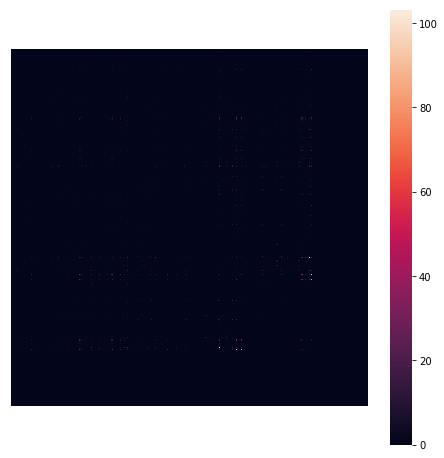

The maximum value of the TECH UNIV DENMARK matrix is in position (200, 286) with value 103.084172194 and concerns biogas and  anaerobic digestion.


In [7]:
univ = 'TECH UNIV DENMARK'
univ_matrix = get_org_matrix(univ, normalization=True)
basic_stats(univ_matrix)


plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(univ_matrix, cbar=True, square=True, yticklabels=False, xticklabels=False)
plt.show()


i,j = np.unravel_index(univ_matrix.argmax(), univ_matrix.shape)
print 'The maximum value of the {} matrix is in position {} with value {} and concerns {} and {}.'.format(univ, (i, j), univ_matrix[i,j], matrix_axis_names[i], matrix_axis_names[j])

In [8]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

In [9]:
print len(organizations)

10638


In [10]:
# query orgs
assetLimit = 7
org_available_q = """     MATCH (n:Asset)
                            WITH n.owner as ORG
                            RETURN ORG, count(ORG)
                            ORDER BY count(ORG) DESC"""

# create a list with the years where records exist from 1 to remove null
raw_data = DataFrame(connection_to_graph.data(org_available_q)).as_matrix()[1::] 
list_of_organizations = []
for row in raw_data:
    if row[1] >= assetLimit:
        list_of_organizations.append(row[0])

organizations = list_of_organizations
print 'The list of organizations now has {} organizations.'.format(len(organizations))

The list of organizations now has 108 organizations.


In [11]:
# create dictionnary
org_capability_dict = {}
counter = 0

# iterate through countries
for org in organizations:
    
    counter += 1
    org_matrix = get_org_matrix(org.encode('utf-8').strip(), normalization=True)
    
    # discart if no information
    if np.all(np.isnan(org_matrix)):
        continue
    else: 
        org_capability_dict[org] = get_list_from(org_matrix)
        
    #print org, sum(get_list_from(org_matrix))

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



In [12]:
def calculate_org_correlation(org1_list, org2_list, stat):
    avg_dif = np.mean(org1_list - org2_list)
    abs_avg_dif = abs(avg_dif)
    
    if stat.lower() == 'absolute average difference': # return absolute average difference
        return abs_avg_dif
    if stat == 'Pearson':                             # return Pearson coef
        return stats.pearsonr(org1_list, org2_list)[0]
    if stat == 'P-value':                             # return P-value
        return stats.pearsonr(org1_list, org2_list)[1]

In [13]:
org_names = org_capability_dict.keys()
org_names.sort()
number_of_orgs = len(org_names)
org_correlation = np.zeros([number_of_orgs, number_of_orgs])


for row in range(number_of_orgs):
    org_1 = org_names[row]
    org_1_list = np.asarray(org_capability_dict[org_1])
    for column in range(number_of_orgs):
        org_2 = org_names[column]
        org_2_list = np.asarray(org_capability_dict[org_2])

        org_correlation[row, column] = calculate_org_correlation(org_1_list, org_2_list, 'Pearson')
        

In [14]:
print len(sorted(org_capability_dict.keys()))

105


In [17]:
print 'Minimum correlation value is {} for organizations {} and {}.'.format(org_correlation[np.unravel_index(org_correlation.argmin(),
                                             org_correlation.shape)[0],
                            np.unravel_index(org_correlation.argmin(), 
                                             org_correlation.shape)[1]],
        org_names[np.unravel_index(org_correlation.argmin(), 
                                       org_correlation.shape)[0]], 
        org_names[np.unravel_index(org_correlation.argmin(), 
                                       org_correlation.shape)[1]])

Minimum correlation value is -0.00233494612769 for organizations ABENGOA BIOENERGIA NUEVAS TECNOLOGIAS SA and FOREST CONCEPTS LLC.


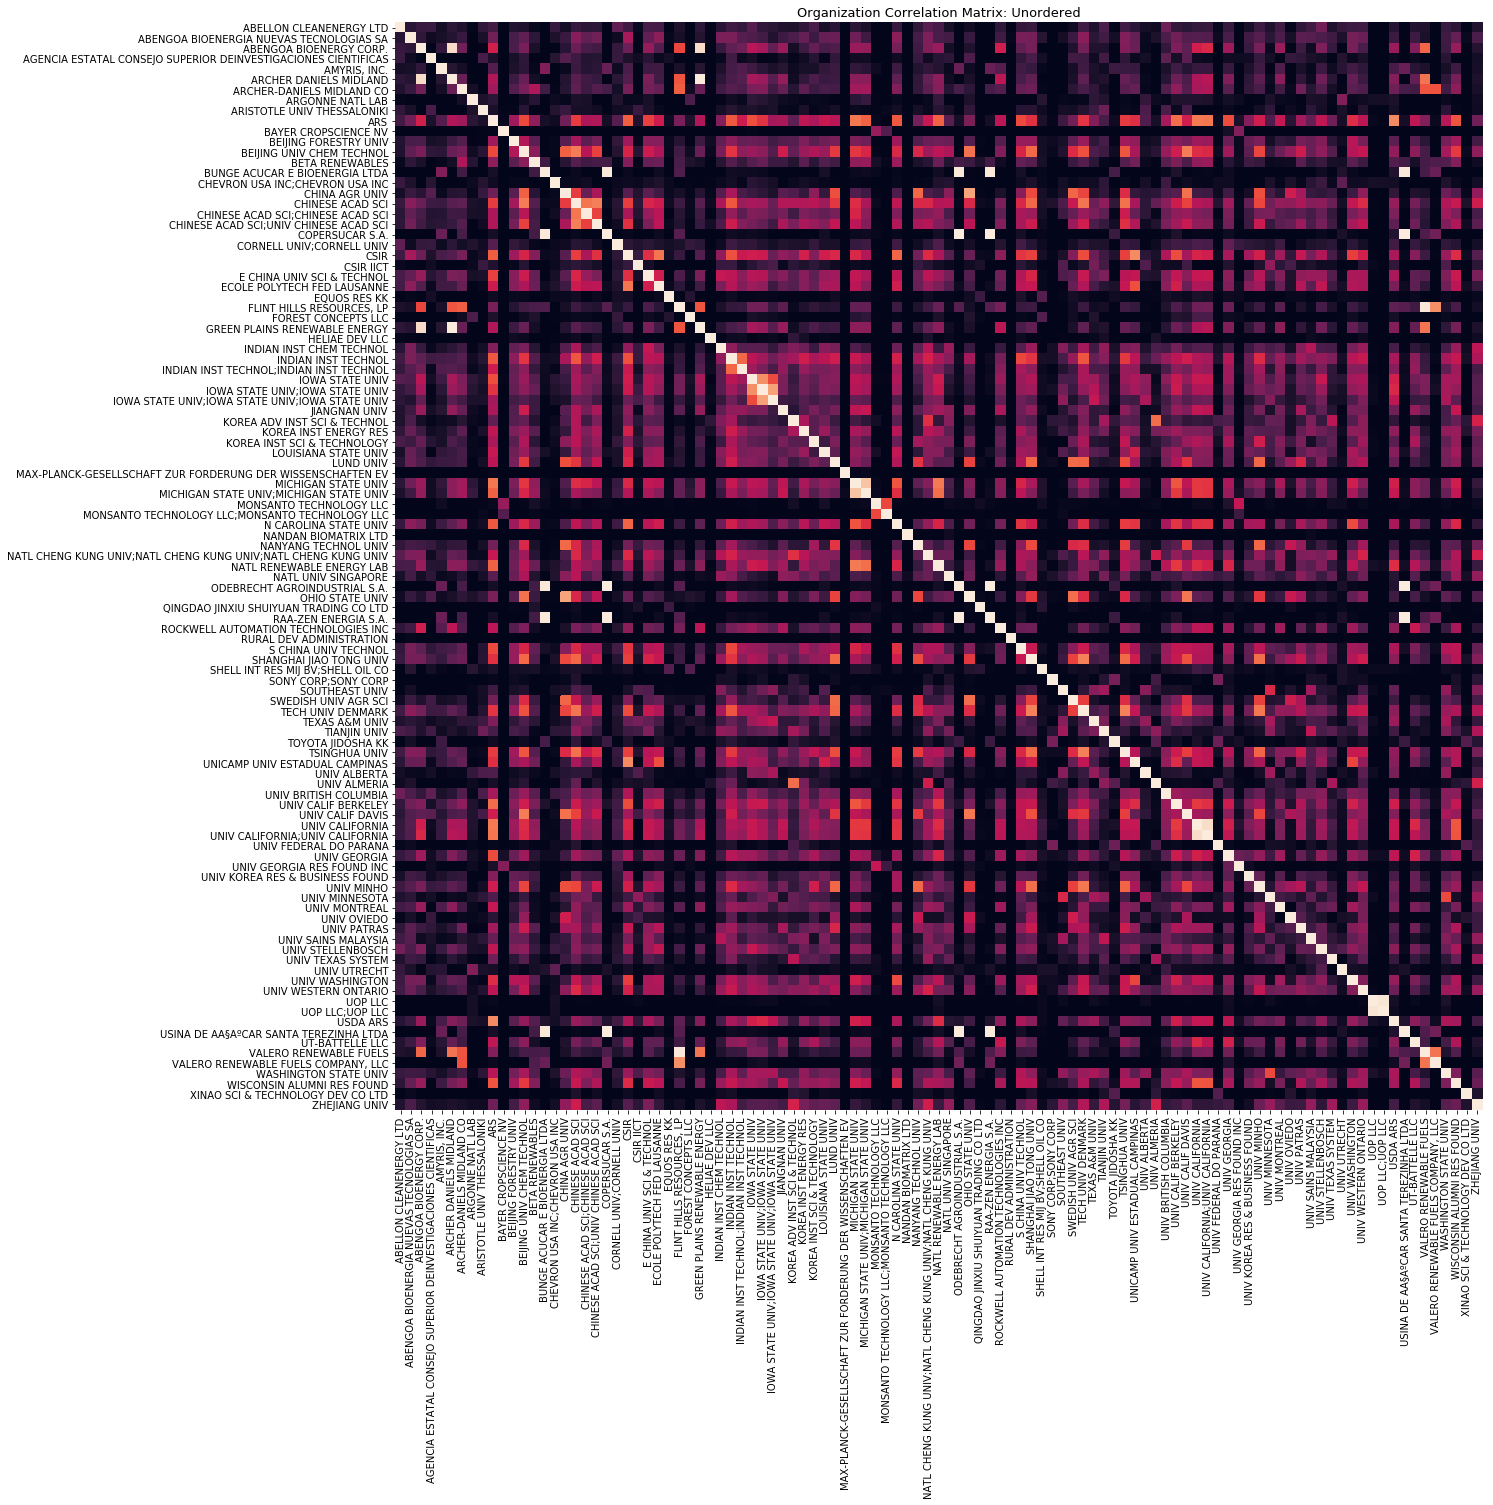

In [19]:
plt.subplots(1,1,figsize=(20, 20))
plt.subplot(111)
sns.heatmap(org_correlation, cbar=None, square=True, yticklabels=org_names, xticklabels=org_names)
plt.title('Organization Correlation Matrix: Unordered', size=13)
plt.show()

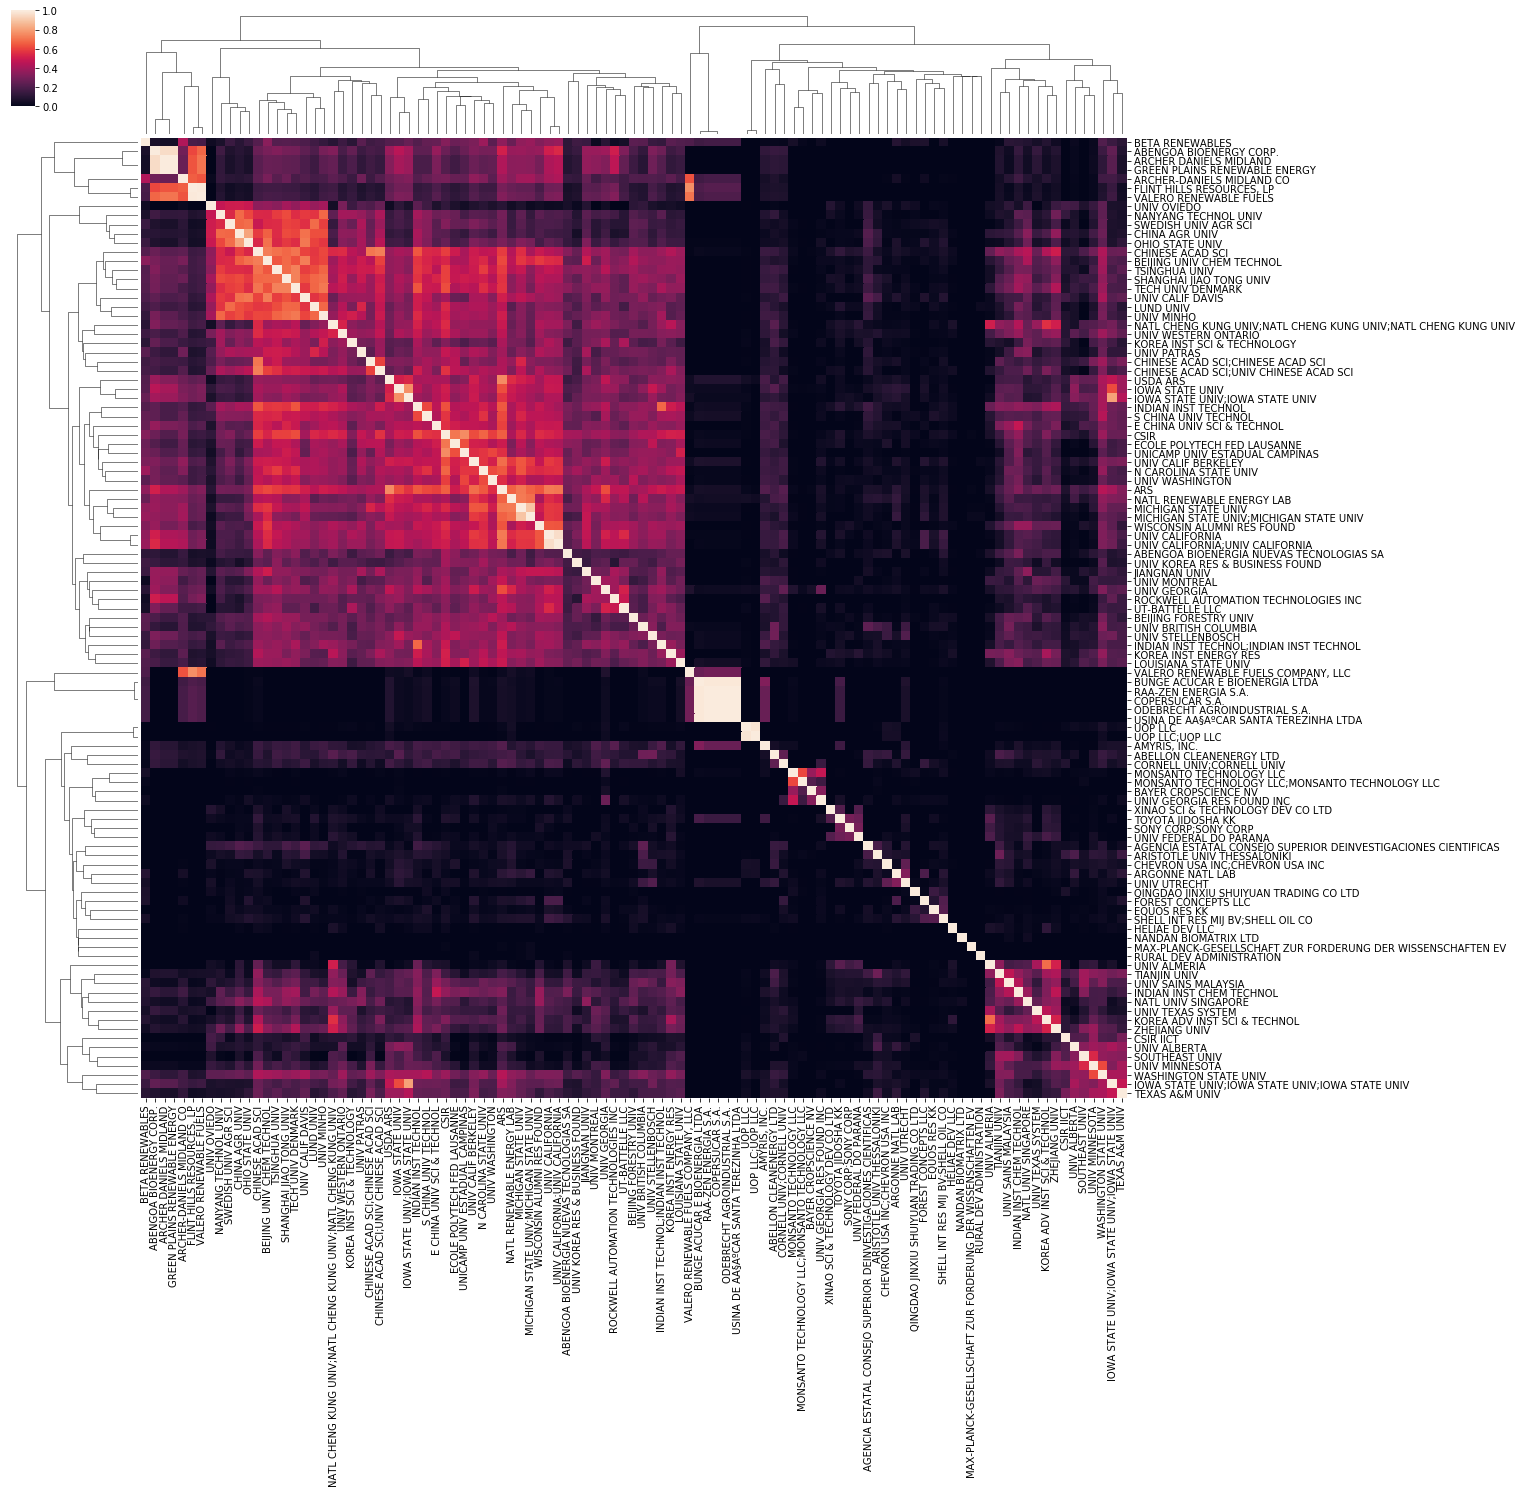

In [21]:
# plot the clustermap
a = sns.clustermap(org_correlation,  figsize=(20, 20), xticklabels = org_names, yticklabels=org_names)
plt.show()

In [43]:
foc_org = ['TECH UNIV DENMARK', 'TSINGHUA UNIV']

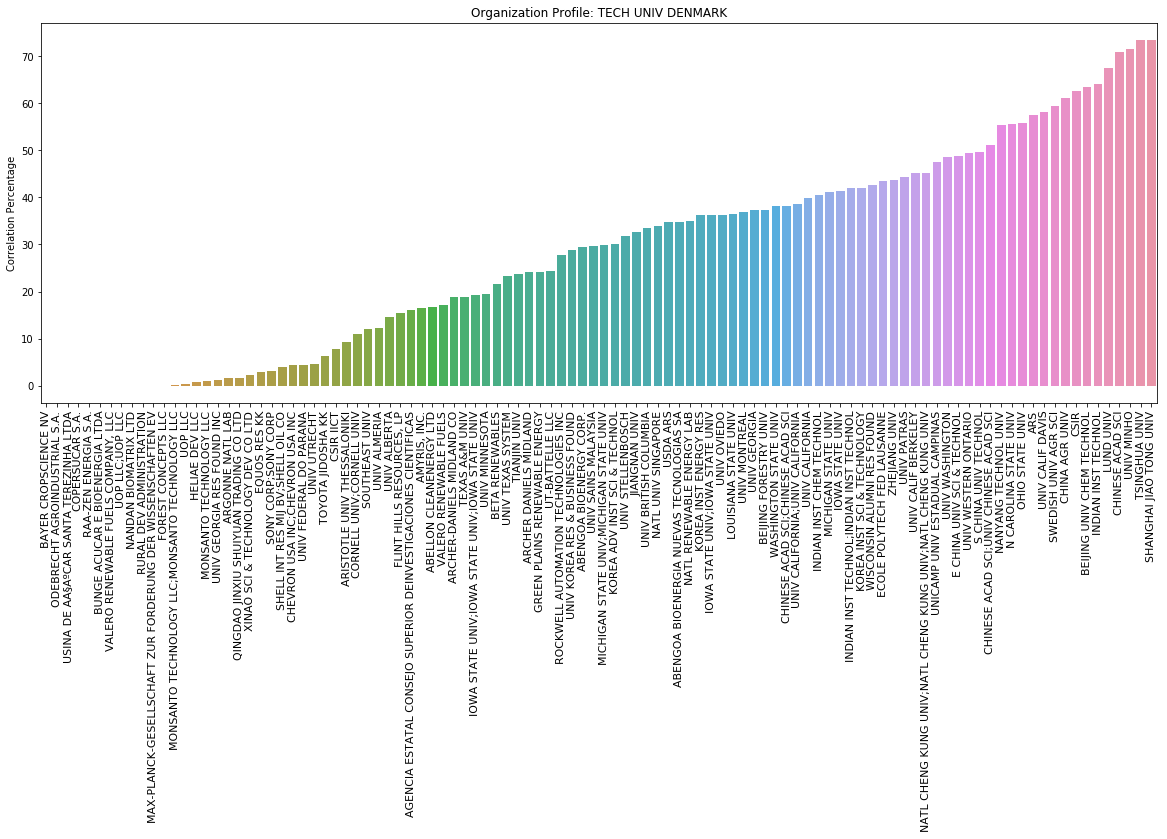

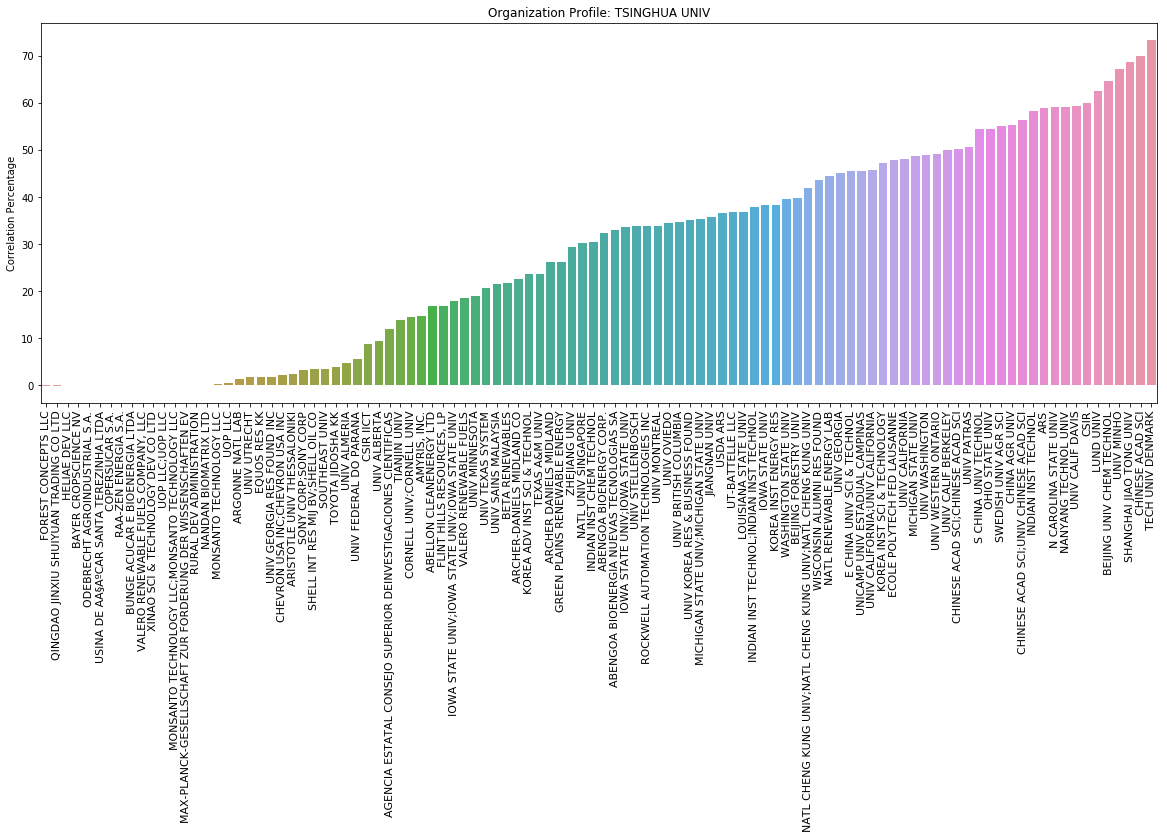

In [44]:
# for each country selected
for org in foc_org:
    
    # find the matrix slice
    org_index = find_index(org, org_names)
    histogram_data = org_correlation[:, org_index]
    
    # remove the country itself from data and labels
    histogram_data = np.delete(histogram_data, org_index)
    clean_org_names = np.delete(org_names, org_index)
    

    # sort labels and data
    sorted_names = [name for _,name in sorted(zip(histogram_data, clean_org_names))]
    histogram_data.sort()
    
    #plot
    plt.subplots(1,1,figsize=(20,7))
    sns.barplot(np.arange(len(histogram_data)), histogram_data * 100)
    plt.xticks(np.arange(len(histogram_data)), sorted_names, rotation=90, fontsize=11)
    plt.title('Organization Profile: {}'.format(org))
    plt.ylabel('Correlation Percentage')
    plt.show()

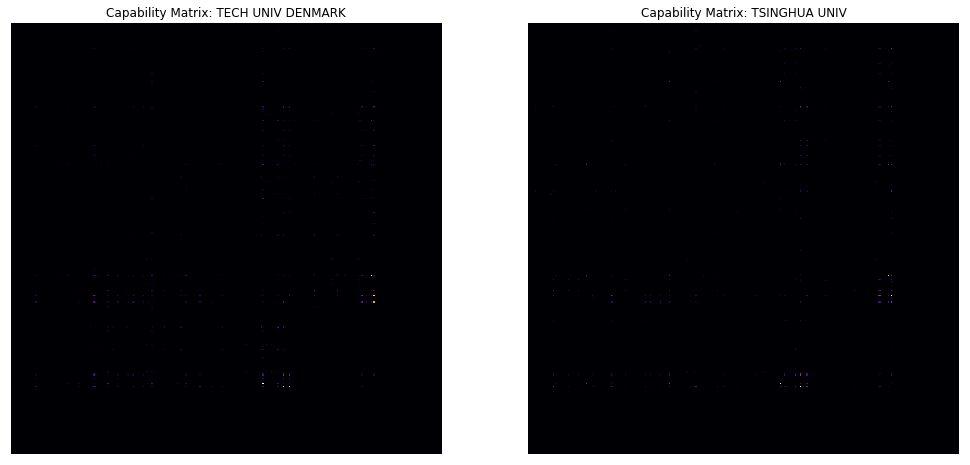

In [46]:
# call functions
dtu = 'TECH UNIV DENMARK'
compare_with = 'TSINGHUA UNIV'
colors = 'magma'
dtu_matrix = get_org_matrix(dtu, normalization=False)
scnd_matrix = get_org_matrix(compare_with, normalization=False)

# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(dtu_matrix, cmap=colors,  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(dtu))

# second heatmap
plt.subplot(122)
sns.heatmap(scnd_matrix, cmap=colors, cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(compare_with))
plt.show()

In [48]:
cap_diff = np.absolute(dtu_matrix - scnd_matrix)

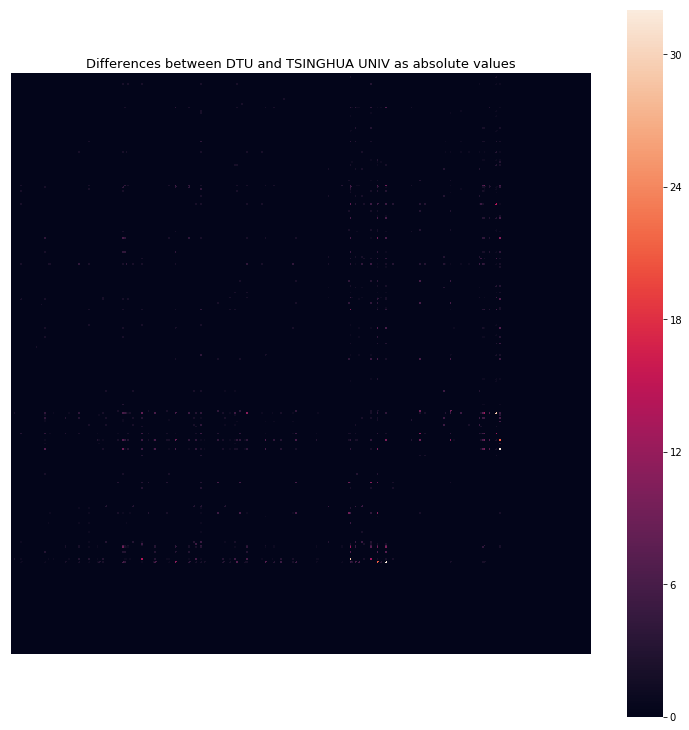

In [50]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(cap_diff, square=True, yticklabels=False, xticklabels=False)
plt.title('Differences between DTU and {} as absolute values'.format(compare_with), size=13)
plt.show()

In [51]:

def get_top_hits(orgMatrix, name):
    """
    The function prints the top occurences if fed a matrix of occurences, it also prints other types of valuable info.
    WARNING: Percentages are shown as 0 to 1. 
    """
        
    # list where all the values and indexes of matrix are stored
    top = 10
    values = []
    indexes = []
    no_duplicates = np.triu(orgMatrix, 1)
    total_documents = np.sum(no_duplicates)
    
    
    # loop through the matrix
    for row_n in range(dtu_matrix.shape[0]):
        for col_n in range(dtu_matrix.shape[1]):
            values.append(no_duplicates[row_n, col_n])
            indexes.append((row_n, col_n))
    
    
    # order the indexes and get the top
    Z = [indexes for _,indexes in sorted(zip(values,indexes))]
    extremes = Z[-top :]
    
    
    # create dataframe
    term_Dataframe = pd.DataFrame(
        {'First Term': [matrix_axis_names[e[0]] for e in extremes],
         'Second Term': [matrix_axis_names[e[1]] for e in extremes],
         'Number of Documents': [int(no_duplicates[e[0], e[1]]) for e in extremes], 
         'Percentage' : [no_duplicates[e[0], e[1]] / float(total_documents) for e in extremes], 
        })
    
    # prepare dataframe
    term_Dataframe = term_Dataframe[['First Term', 'Second Term','Number of Documents', 'Percentage']]
    term_Dataframe = term_Dataframe.sort_values('Number of Documents', ascending=False)
    
    
    # print everything
    print 'The top hits for the {} matrix: '.format(name)
    display(HTML(term_Dataframe.to_html(index=False)))
    
    
    print 'The total number of documents is {}.'.format(int(total_documents))
    print 'Note: Percentages are as 0-1 in this table. '

In [52]:
get_top_hits(dtu_matrix, dtu)

The top hits for the TECH UNIV DENMARK matrix: 


First Term,Second Term,Number of Documents,Percentage
biogas,anaerobic digestion,53,0.035811
ethanol,fermentation,47,0.031757
bioethanol,fermentation,42,0.028378
ethanol,hydrolysis,20,0.013514
cellulose,ethanol,17,0.011486
ethanol,enzymatic hydrolysis,17,0.011486
bioethanol,hydrolysis,16,0.010811
cellulose,fermentation,15,0.010135
algae,anaerobic digestion,14,0.009459
ethanol,bioethanol,14,0.009459


The total number of documents is 1480.
Note: Percentages are as 0-1 in this table. 


In [53]:
get_top_hits(scnd_matrix, compare_with)

The top hits for the TSINGHUA UNIV matrix: 


First Term,Second Term,Number of Documents,Percentage
ethanol,fermentation,26,0.042623
biogas,anaerobic digestion,24,0.039344
ethanol,enzymatic hydrolysis,11,0.018033
ethanol,hydrolysis,11,0.018033
sugar,fermentation,10,0.016393
cellulose,ethanol,10,0.016393
waste,anaerobic digestion,10,0.016393
bioethanol,fermentation,10,0.016393
cellulose,fermentation,9,0.014754
waste,biogas,9,0.014754


The total number of documents is 610.
Note: Percentages are as 0-1 in this table. 


In [57]:
# list where all the values and indexes of matrix are stored
dtu_perc = dtu_matrix / np.sum(np.triu(dtu_matrix, 1)) * 100 # half only  
other_perc = scnd_matrix / np.sum(np.triu(scnd_matrix, 1)) * 100
differences = dtu_perc - other_perc
values = []
indexes = []
no_duplicates = np.triu(differences, 1)

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

# print the table 
Z = [indexes for _,indexes in sorted(zip(values,indexes))]
#extremes = Z[0:10] + Z[-10:]
extremes = Z[0:20]


term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in extremes],
     'Second Term': [matrix_axis_names[e[1]] for e in extremes],
     'DTU Percentage': [dtu_perc[e[0], e[1]] for e in extremes], 
     '{} Percentage'.format(compare_with): [other_perc[e[0], e[1]] for e in extremes], 
     'Difference in %': [no_duplicates[e[0], e[1]] for e in extremes]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', 'DTU Percentage', '{} Percentage'.format(compare_with), 'Difference in %']]


display(HTML(term_Dataframe.to_html(index=False)))
print 'Percentages are as 0-100 in this table for easy viz.'

First Term,Second Term,DTU Percentage,TSINGHUA UNIV Percentage,Difference in %
sorghum,fermentation,0.000000,1.147541,-1.147541
biodiesel,hydrolysis,0.000000,1.147541,-1.147541
ethanol,fermentation,3.175676,4.262295,-1.086619
sugar,fermentation,0.608108,1.639344,-1.031236
gasoline,fermentation,0.000000,0.983607,-0.983607
biopolymers,fermentation,0.000000,0.983607,-0.983607
sewage,anaerobic digestion,0.337838,1.311475,-0.973638
sewage,waste,0.405405,1.311475,-0.906070
waste,anaerobic digestion,0.743243,1.639344,-0.896101
sewage,biogas,0.608108,1.475410,-0.867302


Percentages are as 0-100 in this table for easy viz.
